**MLP классификатор (PyTorch)** 

Евгений Борисов  <esborisov@sevsu.ru>

О методах обучения многослойных нейронных сетей прямого распространения.    
http://mechanoid.su/neural-net-backprop.html  
http://mechanoid.su/neural-net-backprop2.html

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=2)

## генерируем данные

In [3]:
n_samples = 1500

# from sklearn.datasets import make_blobs
# X,target = make_blobs( n_samples=n_samples, centers=2,  cluster_std=[1.5, 1.8,] )

# from sklearn.datasets import make_moons
# X,target = make_moons(n_samples=n_samples, noise=.09)

from sklearn.datasets import make_circles
X,target = make_circles(n_samples=n_samples, shuffle=True, noise=.09, factor=.3)
# X = X+(np.random.rand(X.shape[0],X.shape[1])*0.6)


y = np.eye(len(target),2)[target] # [:,np.newaxis]

X.shape, y.shape

((1500, 2), (1500, 2))

In [4]:
# нормируем данные
# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

# from sklearn.preprocessing   import StandardScaler
# X = StandardScaler().fit(X).transform(X)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((750, 2), (750, 2), (750, 2), (750, 2))

In [6]:
del X
del y
del target

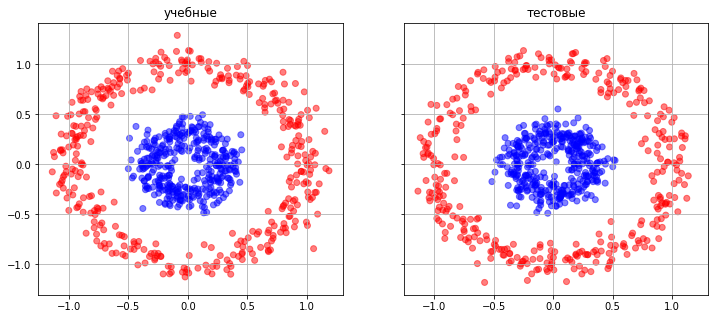

In [7]:
def plot_data(ax,X,y,t):
    c = [ ['b','r','g','y'][j] for j in y.astype(int).flatten()  ]
    ax.set_title(t)
    ax.scatter( x=X[:,0], y=X[:,1], c=c,  alpha=0.5 )
    ax.grid()

fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_train,y_train[:,0],'учебные')    
plot_data(ax1,X_test,y_test[:,0],'тестовые')    
plt.show()

## модель

схема нейрона

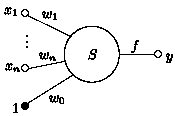

схема MPL 

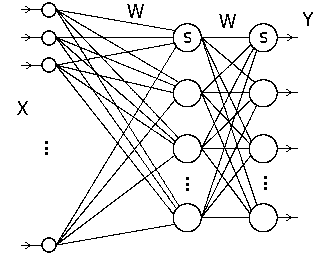

In [8]:
import torch

In [9]:
from torch import nn
from torch import sigmoid

In [10]:
class MLP(nn.Module): 
    
    def __init__(self,input_size,output_size):
        super().__init__()
        
        self.dense1 = nn.Linear(input_size,10) # первый - обрабатывающий  слой 
        self.dense2 = nn.Linear(10,5) # второй - обрабатывающий/скрытый слой
        self.dense3 = nn.Linear(5,output_size) # третий - обрабатывающий/выходной слой

    def forward(self,x):
        o = self.dense1(x)
        o = sigmoid(o)
        
        o = self.dense2(o)
        o = sigmoid(o)
        
        o = self.dense3(o)
        o = sigmoid(o)
        
        return o
    
    def predict(self, x):    
        return self.forward(x)
    

In [11]:
model = MLP( input_size=X_train.shape[1], output_size=y_train.shape[1], )
# model.predict(torch.Tensor(X_train))

## обучаем модель

функция потери средняя квадратичная ошибка
$$L=MSQE(y,o)=\frac{1}{m}\sum\limits_{i=0}^m(o_i-y_i)^2$$

In [12]:
from torch import optim

criterion = nn.MSELoss() # ф-ция потери
optimizer = optim.Adam(model.parameters(), lr=1e-2) # метод оптимизации ф-ции потери

In [13]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# пакуем данные в формат Torch
dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train) )

In [14]:
# используем GPU если есть
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [15]:
model = model.to(device)

In [17]:
from sklearn.metrics import accuracy_score

def accuracy(x,y):
    with torch.set_grad_enabled(False):
        o = np.argmax( model.predict(torch.Tensor(x).to(device)).cpu().numpy(),axis=1 )
    return accuracy_score(y[:,1],o)

acc_history = [ accuracy(X_train,y_train) ] # начальное значение погрешности

In [19]:
with torch.set_grad_enabled(False):
    loss = criterion( 
            torch.Tensor(y_train).to(device), 
            model.predict( torch.Tensor(X_train).to(device) ) 
        ).cpu().numpy().flatten()[0]
    
loss_history = [ loss ] # начальное значение ф-ции потери

In [20]:
from tqdm import tqdm

In [21]:
%%time

n_epoch = 500 # количество эпох обучения
acc_min = .98 # порог минимально допустимой погрешности модели

for i in tqdm(range(n_epoch)): 
    
    for x,y in DataLoader(dataset, batch_size=len(y_train)//3, shuffle=True): # получаем батч учебных примеров
        out = model.forward(x.to(device)) # считаем выход модели
        loss = criterion( y.to(device),out ) # вычисляем значение ф-ции потери
        loss_history.append(loss.item()) # дополняем историю изменения значений ф-ции потери
        optimizer.zero_grad() # очищаем предыдущее значение градиента
        loss.backward()  # вычисляем текущее значение градиента ф-ции потери
        optimizer.step() # корректируем параметры модели
        
    acc_history.append( accuracy(X_train,y_train) ) #значение погрешности
    if acc_history[-1] > acc_min: # проверяем достижение минимального порога погрешности модели
        print('step %i/%i: loss %.03f, acc threshold %.03f reached\n'%(i+1,n_epoch,loss_history[-1],acc_min))
        break

 16%|█▌        | 80/500 [00:00<00:04, 97.45it/s] 

step 81/500: loss 0.057, acc threshold 0.980 reached

CPU times: user 634 ms, sys: 7.91 ms, total: 642 ms
Wall time: 824 ms


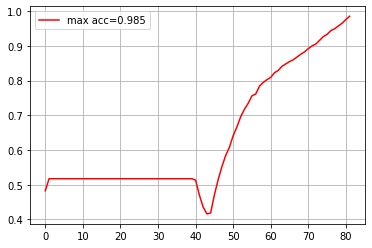

In [22]:
# история изменения значений погрешности модели
plt.plot(acc_history,label='max acc=%.3f'%(max(acc_history)),c='r')
plt.grid()
plt.legend()

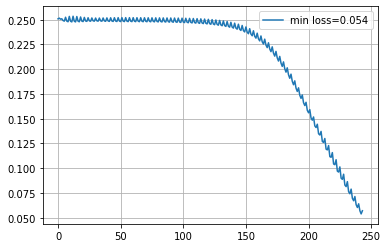

In [23]:
# история изменения значений ф-ции потери
plt.plot(loss_history,label='min loss=%.3f'%(min(loss_history)))
plt.grid()
plt.legend()

## тестируем модель

In [27]:
with torch.set_grad_enabled(False):
    s = model.predict( torch.Tensor(X_test).to(device)).cpu().numpy()[:,1]

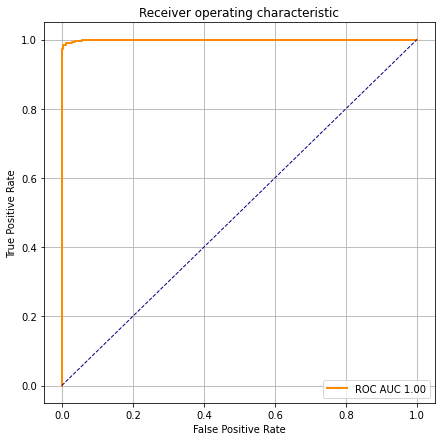

In [28]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve( y_test[:,1], s )
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
plt.grid(True)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC AUC %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [29]:
# оптимальный порого скора 
#  максимальное количество True Positive при минимальном количестве False Positive
optimal_threshold = thresholds[ np.argmax( np.abs(tpr-fpr) )  ]
optimal_threshold

0.58485633

In [30]:
p = (s>optimal_threshold).astype(int)
y = y_test[:,1].astype(int)

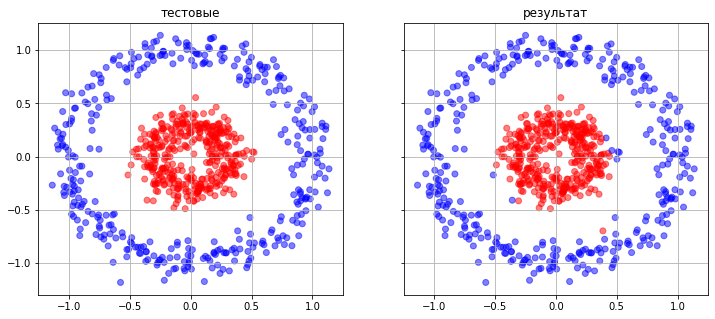

In [31]:
fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_test,y,'тестовые')    
plot_data(ax1,X_test,p,'результат')    
plt.show()

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y,p))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       362
           1       1.00      0.98      0.99       388

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750



## карта скоров

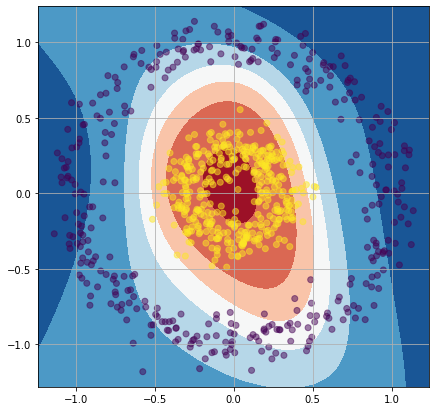

In [34]:
# строим сетку и определяем значения скора классификатора во всех узлах

n=500 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-.1, X_test[:,0].max()+.1, n), 
    np.linspace( X_test[:,1].min()-.1, X_test[:,1].max()+.1, n)
) # узлы сетки

xy = np.vstack([xx.flatten(),yy.flatten() ]).T # разворачиваем сетку 


with torch.set_grad_enabled(False):
    s = model.predict( torch.Tensor(xy).to(device)).cpu().numpy()[:,1]

plt.figure(figsize=(7,7))
plt.contourf(xx, yy, (1.-s).reshape(n,n), cmap=plt.cm.RdBu)
plt.scatter( x=X_test[:,0], y=X_test[:,1], c=y_test[:,1].astype(int), alpha=.5 )
plt.grid()